In [1]:
# !kaggle datasets download -d mohamedbakhet/amazon-books-reviews
# !mv amazon-books-reviews.zip ../data/


# Executive summary

1. Objective: Develop a model to predict whether a book review is positive.

2. Logistic Regression appears to be the most stable model when using input data provided by a TFIDF vectorizer.

3. An F1 score of 0.94 and 0.86 AUC score was achieved on the test dataset.

4. Despite this, deeper analysis indicates the model still underperforms. Alternative strategies may be required.


NOTE: 
* I've reused some parts of Unsupervised Algorithms Final Project and Supervised Algorithms Final Project
* The detailed code mechanism is presented under Report - real summary.

# Plan

1. Dataset description
2. Cleaning dataset
3. Dataset stats
4. Vocab analysis
5. Ngram analysis
6. Other features
7. TFiDF launch
9. Hyperparameter search - phase I
10. Hyperparameter search - phase II
11. Final model stats
12. Conclusion

# Libraries

In [2]:
!pwd

/workspace/introduction-to-deep-learning-boulder/notebooks


In [40]:
# Libraries

from pandarallel import pandarallel
import sys
import nltk
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import sys
sys.path.append("..")

from flashtext import KeywordProcessor
from constant import MAPPING_OVERALL_TO_SENTIMENT, MAPPING_SENTIMENT_TO_NUMBER
from sklearn.metrics import f1_score
nltk.download("wordnet")
from data_preprocessors.data_cleaner import DataCleaner
from data_preprocessors.spacy_analyzer import SpacyAnalyzer
from data_preprocessors.correction_heuristics_executor import (
    CorrectionHeuristicsExecutor,
)
from pandarallel import pandarallel
import numpy as np
import pandas as pd
import re
from dataclasses import dataclass
from tqdm import tqdm
from glob import glob
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
import sys
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import numpy as np
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import evaluate
from sklearn.metrics import confusion_matrix
import sklearn.metrics  as metrics
import sklearn.metrics  as metrics

pandarallel.initialize(progress_bar=True, nb_workers=10)

[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


FileNotFoundError: [Errno 2] No such file or directory: '../data/big.txt'

# About dataset

Source: [Kaggle - Amazon Books Reviews](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews)

This dataset contains approximately 3 million book reviews for 212,404 unique books, along with user information for each review. However I used only 140000 rows to conduct the Exploratory Data Analysis (EDA). Let's delve deeply into the data!

In [4]:
# !rm -R ../data
!mkdir -p  ../data

In [5]:

train_data = pd.read_csv(
    "../data/Books_rating.csv",
    names=[
        "asin",
        "title",
        "price",
        "userId",
        "profileName",
        "reviewHelpfulness",
        "overall",
        "reviewTime",
        "reviewSummary",
        "reviewText",
    ],
)

/tmp/ipykernel_1675/1334125578.py:1: DtypeWarning: Columns (2,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(


In [6]:
train_data = train_data.head(140000)

In [7]:
train_data

,asin,title,price,userId,profileName,reviewHelpfulness,overall,reviewTime,reviewSummary,reviewText
0,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
2,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
3,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
4,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
...,...,...,...,...,...,...,...,...,...,...
139995,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A26ZAM8KFU0GY9,Jim Estill,0/2,4.0,1155081600,How to Thrive,I read Collapse by Jared Diamond. This is an a...
139996,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A3KKUNIFVEAHNC,saskatoonguy,7/14,2.0,1143244800,Intriguing bits of world history plus sky-is-f...,Most of this book consists of stories of faile...
139997,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A1ALF72BQ4RIEL,Bill Pen Name,4/9,5.0,1137024000,A Must Read for all Thoughtful People,This work would rate at the top of the scale j...
139998,B0007PC4ZM,Collapse: How Societies Choose to Fail or Succeed,NaN,A1ZS0YNUQ4UAJ2,Susan Norton,4/9,5.0,1107561600,Full of interest,I'm not sure if I agree with everything in thi...


# Cleaning training data

In order to get cleaner text (without typos and unknown words), I have:
- removed duplicated punctuations,
- converted emojis to the word equivalents (e.g. kiss mark),
- removed unknown words from pov of wordnet, 
- removed characters that occur more than 2 times consequtively, 
- converted compound words that are mistakenly written into separate words
etc. 


In [8]:
!rm -R train_spans # clean up resources

The dataset contains initially 140000 rows. Let's collect infos about lemmas, part of sequence taggings. For this exercise I used SpacyAnalyzer processor, as well as custom CorrectionHeuristicsExecutor. This entire sequence is about reducing effect of typos and misclicks on the quality of the data (I used i.a. Viterbi algorithm).

In [9]:
data_cleaner = DataCleaner(train_data)
data_cleaner.preprocess()
data_cleaner.data = data_cleaner.data[
    ~(data_cleaner.data.reviewText == "")
].reset_index(drop=True)

08-17 05:46 data_preprocessors.data_cleaner INFO     Words that are uppercase are converted to lowercase


08-17 05:47 data_preprocessors.data_cleaner INFO     Contraction converted to two words sequences


08-17 05:47 data_preprocessors.data_cleaner INFO     HTML characters dropped


08-17 05:47 data_preprocessors.data_cleaner INFO     Emojis dropped


08-17 05:47 data_preprocessors.data_cleaner INFO     Duplicate punctuation removed


08-17 05:47 data_preprocessors.data_cleaner INFO     Removed more than 3 consecutive same characters


08-17 05:47 data_preprocessors.data_cleaner INFO     Add space after punctuation


08-17 05:47 data_preprocessors.data_cleaner INFO     Duplicate spaces removed
08-17 05:47 data_preprocessors.data_cleaner INFO     Cleaning process ended


In [10]:
data_cleaner.data.to_csv("../data//_train_after_cleaning.csv", encoding="utf-8")
analyzer = SpacyAnalyzer(
    path_to_data="../data//_train_after_cleaning.csv",
    chunk_size=30000,
    destination_folder="train_spans",
)
analyzer.extract_spacy_spans()
lemmas = analyzer.collect_info_about_words("lemma")
only_lemmas = [
    word[1] for sequence in lemmas for sentence in sequence for word in sentence
]
only_lemmas = list(set(only_lemmas))
data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
executor = CorrectionHeuristicsExecutor(only_lemmas)
texts = executor.preprocess(data)

08-17 05:48 data_preprocessors.spacy_analyzer INFO     Spacy analysis started
100%|████████████████████| 5/5 [18:05<00:00, 217.00s/it]
08-17 06:06 data_preprocessors.spacy_analyzer INFO     Spacy analysis ended
/tmp/ipykernel_1675/1394957835.py:13: DtypeWarning: Columns (3,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data//_train_after_cleaning.csv", index_col=0)
08-17 06:07 data_preprocessors.correction_heuristics_executor INFO     Words will be corrected into known words or removed
100%|█| 140000/140000 [00:51<00:00, 
08-17 06:08 data_preprocessors.correction_heuristics_executor INFO     Pipeline ended


In [11]:
with open("default_excluded_words.pkl", "rb") as f:
    correct_word_map_to_none = pickle.load(f)

with open("default_corrected_words.pkl", "rb") as f:
    correct_word_map = pickle.load(f)


text_lemmatized = [
    " ".join(" ".join([word[1].lower() for word in sentence]) for sentence in sequence)
    for sequence in lemmas
]

keyword_processor = KeywordProcessor()


for word, target_word in correct_word_map_to_none.items():
    keyword_processor.add_keyword(word, target_word)
for word, target_word in correct_word_map.items():
    keyword_processor.add_keyword(word, target_word)


new_texts = []
for i in tqdm(text_lemmatized):
    new_texts.append(keyword_processor.replace_keywords(i))

new_texts = [i.lower() for i in new_texts]

  0%|          | 0/140000 [00:00<?, ?it/s]

In [12]:
data["cleaned sentences"] = texts

In [13]:
len(new_texts)

140000

In [14]:
data.shape

(140000, 11)

In [15]:
data["text_lematized"] = new_texts

In [16]:
data["length"] = train_data.reviewText.str.len()

In [17]:
# removing 30000 outliers
data = data[np.logical_and(data["length"] < 2500, data["length"] > 100)]

In [18]:
data.reset_index(drop=True).to_csv("../data/final_train_data.csv")

In [19]:
train_data.groupby("title").size().sort_values(ascending=False)

title
The Hobbitt, or there and back again; illustrated by the author.                                                           4420
Fahrenheit 451                                                                                                             3287
ERAGON: INHERITANCE, BOOK ONE.                                                                                             3137
1984                                                                                                                       1895
Great Expectations                                                                                                         1643
                                                                                                                           ... 
Nudes                                                                                                                         1
Nurturing Change through Your Human Assets: Optimising Organisational Challenges in the New Millen

# Short overview

Cleaned data contains unique 124601 reviews  on 15103 books. Some of them are spams, some laconic, some are examples of the very good piece of writing. 

In [14]:
train_data = pd.read_csv("../data/final_train_data.csv")

In [15]:
len(train_data.reviewText.unique())

119791

In [17]:
len(train_data.title.unique())

9008

In [18]:
print(
    train_data[
        train_data.reviewText.str.len() == train_data.reviewText.str.len().max()
    ].reviewText.values[0][:1000]
)

Forget Alvin Schwartz! The stories in these books are merely collected from folklore. they are nothing but old campfire tales. They are told in a very basic format that did not invoke any feelings of fear in my little 12 year old mind back in good old ' 92. Hey, i even think there was some sort of appendix in the back that provided more real- world explainations of some of the stories or where the old folklore came from. h. p. Lovecraft said that the greatest fear is fear of the unknown. I will say that the stories alone would have given these books maybe three stars. It' s the pictures. They are so beautifully crafted and surreal. You cannot quite make out the details, yet at the same time, everything that is rotten or dilapidated stands out right away. i have never seen the style anywhere else, not in any art book, not in any museum, not in any history book, nothing! Stephen Gammell is truly an artist. i do not care about all those artists that slap a bunch of shapes together and the

In [19]:
try:
    print(train_data[train_data.reviewText.str.len() < 100].reviewText.values[0][:1000])
except:
    pass

In [20]:
train_data["sentiment"] = train_data["overall"].apply(
    lambda x: MAPPING_OVERALL_TO_SENTIMENT[x]
)

08-18 08:33 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
08-18 08:33 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
08-18 08:33 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
08-18 08:33 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/workspace/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
08-18 08:33 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/workspace/venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
08-18 08:33 matplotlib.font_manager DEBUG    findfont: score(FontEntry

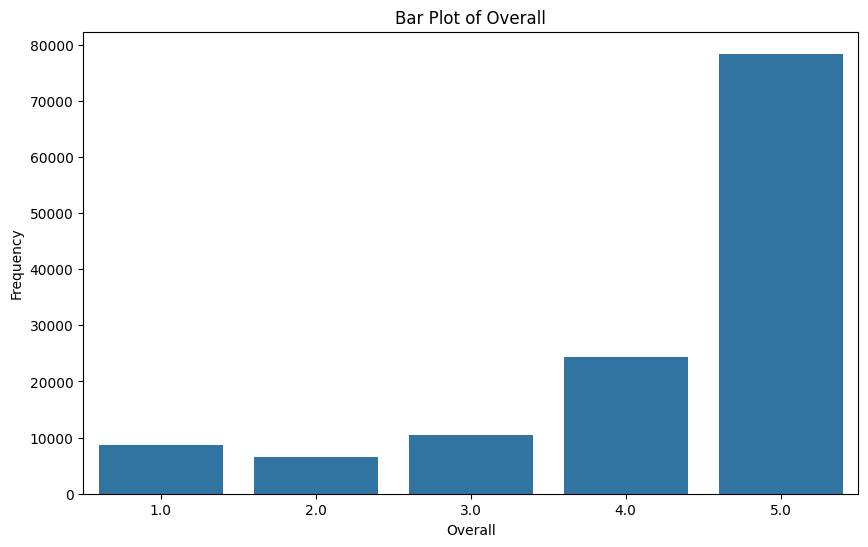

In [21]:
plt.figure(figsize=(10, 6))
ordered_overall = sorted(train_data["overall"].fillna(3.0).unique())
sns.countplot(x="overall", data=train_data, order=ordered_overall)

plt.title("Bar Plot of Overall")
plt.xlabel("Overall")
plt.ylabel("Frequency")
plt.show()

# Vocab analysis

Analysis of vocabulary from a part of speech perspective might be useful, especially if we would like to examine how the text of a typical review is constructed.

In [29]:
analyzer = SpacyAnalyzer(
    path_to_data="../data/final_train_data.csv",
    chunk_size=30000,
    destination_folder="train_spans/",
)
poses = analyzer.collect_info_about_words("pos")

<Axes: ylabel='Frequency'>

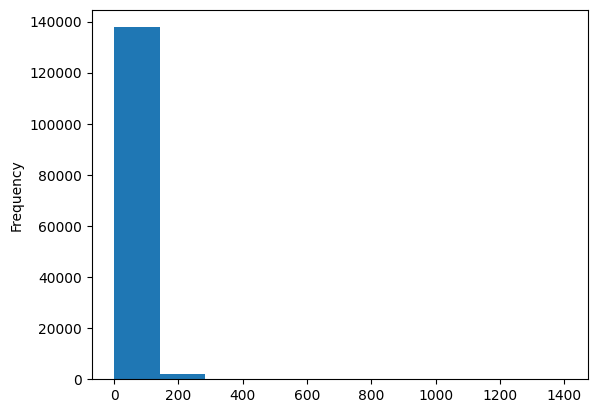

In [31]:
from collections import Counter
counted_poses = [
    Counter([word[1] for sentence in sequence for word in sentence])
    for sequence in poses
]

counted_poses = [dict(count) for count in counted_poses]


poses_matrix = pd.DataFrame(counted_poses)

poses_matrix["NOUN"].plot.hist()

In [32]:
noun_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "NOUN"
]
verb_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "VERB"
]
adjective_occurences = [
    word[0]
    for sequence in poses
    for sentence in sequence
    for word in sentence
    if word[1] == "ADJ"
]

In [33]:
noun_occurences = Counter(noun_occurences)

In [34]:
results = sorted(dict(noun_occurences), key=lambda x: noun_occurences[x], reverse=True)
{key: noun_occurences[key] for key in results[:30]}

{'book': 268128,
 'story': 56816,
 'books': 45522,
 'time': 43044,
 'life': 36458,
 'people': 32506,
 'characters': 30097,
 'novel': 29197,
 'way': 27638,
 'world': 23254,
 'author': 23250,
 'years': 22366,
 'series': 18167,
 'reader': 17150,
 'work': 17148,
 'man': 16395,
 'character': 15993,
 's': 15843,
 'one': 15644,
 'things': 15207,
 'love': 13979,
 'read': 13754,
 'history': 13624,
 'times': 13126,
 'end': 12971,
 'stories': 12913,
 'lot': 12482,
 'family': 12279,
 'part': 12233,
 'plot': 12135}

In [35]:
verb_occurences = Counter(verb_occurences)

In [36]:
results = sorted(dict(verb_occurences), key=lambda x: verb_occurences[x], reverse=True)
{key: verb_occurences[key] for key in results[:30]}

{'read': 96019,
 's': 43573,
 'have': 43138,
 'reading': 29172,
 'has': 27831,
 'get': 25478,
 'think': 25160,
 'had': 23603,
 'written': 22660,
 'know': 21912,
 'find': 21043,
 'make': 20229,
 'found': 18763,
 'see': 18237,
 'do': 17471,
 'recommend': 16078,
 'want': 15951,
 'say': 15219,
 'is': 15104,
 'made': 14836,
 'like': 14754,
 'makes': 13874,
 'love': 13330,
 'are': 13189,
 'go': 12966,
 'put': 12899,
 'understand': 11503,
 'going': 11478,
 'thought': 11160,
 'take': 10900}

In [37]:
adjective_occurences = Counter(adjective_occurences)

In [38]:
results = sorted(
    dict(adjective_occurences), key=lambda x: adjective_occurences[x], reverse=True
)
selected_results = {key: adjective_occurences[key] for key in results[:50]}

In [39]:
selected_results

{'good': 39284,
 'great': 36601,
 'other': 35960,
 'many': 35082,
 'more': 29030,
 'first': 25212,
 'best': 18765,
 'little': 18407,
 'own': 18198,
 'new': 17273,
 'interesting': 15263,
 'much': 14555,
 'old': 14062,
 'few': 13348,
 'same': 12873,
 'most': 12444,
 'such': 12413,
 'different': 12199,
 'real': 11642,
 'better': 11437,
 'young': 11257,
 'true': 9985,
 'wonderful': 9834,
 'human': 9065,
 'last': 9030,
 'easy': 8800,
 'excellent': 8703,
 'only': 8475,
 'hard': 8010,
 'bad': 7839,
 'main': 7694,
 'long': 7575,
 'short': 7514,
 'important': 7440,
 'able': 7255,
 'worth': 7213,
 'several': 7049,
 'next': 6711,
 'second': 6466,
 'whole': 6449,
 'full': 6417,
 'high': 6313,
 'small': 6061,
 'least': 6036,
 'sure': 5956,
 'interested': 5939,
 'favorite': 5811,
 'historical': 5810,
 'modern': 5735,
 'beautiful': 5616}

Definitely, some words should be removed because they do not indicate any specific topic and could reduce the effectiveness of the TF-IDF vectorizer.

# Vocabulary analysis per ngram and sentiment type. 

Let's analyse corpus for mixed, negative and positive reviews from this perspective.

## Positive ngrams

In [40]:
@dataclass
class VectorizerData:
    ngram: int
    sentiment: str
    vectorizer: CountVectorizer
    sum_words: np.array
    words_freq: np.array

In [41]:
with open("stopwords-en.txt") as f:
    stop_words = f.read().splitlines()

In [42]:
def get_top_ngram(sentiment, n=None):
    # https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=stop_words)
    bag_of_words = vectorizer.fit_transform(
        train_data[train_data.sentiment == sentiment]["reviewText"]
    )
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return VectorizerData(
        ngram=n,
        sentiment=sentiment,
        vectorizer=vectorizer,
        sum_words=sum_words,
        words_freq=words_freq,
    )

In [43]:
positive_1_gram = get_top_ngram("positive", 1)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

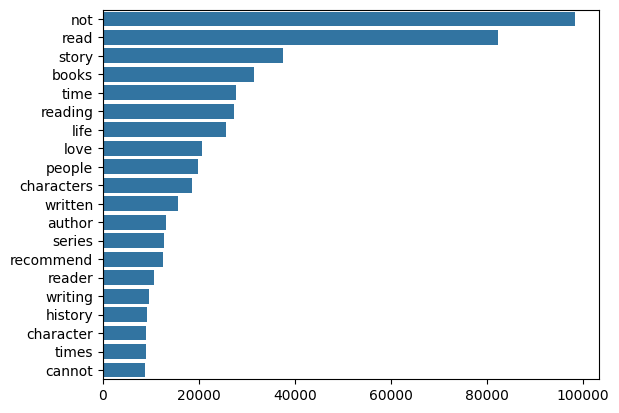

In [44]:
x, y = map(list, zip(*positive_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [45]:
positive_2_gram = get_top_ngram("positive", 2)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

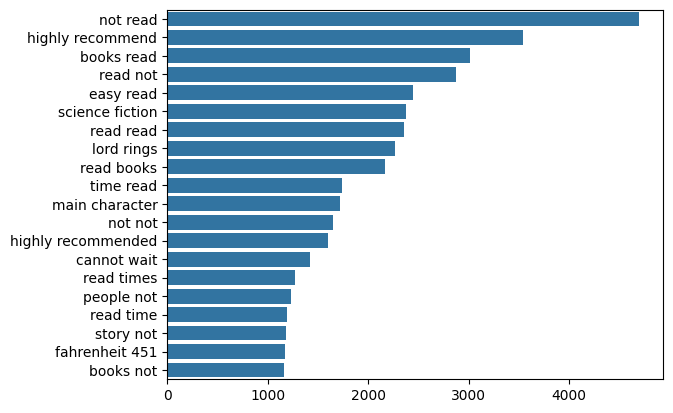

In [46]:
x, y = map(list, zip(*positive_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [47]:
positive_3_gram = get_top_ngram("positive", 3)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

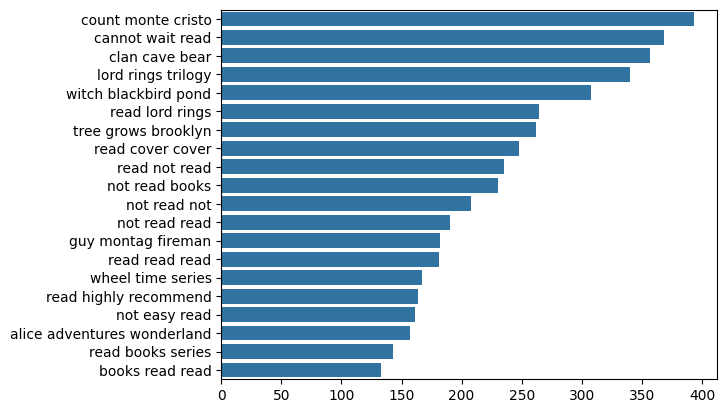

In [48]:
x, y = map(list, zip(*positive_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Negative ngrams

In [49]:
negative_1_gram = get_top_ngram("negative", 1)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

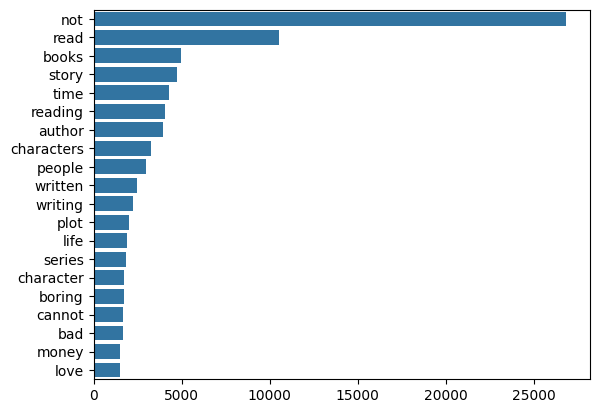

In [50]:
x, y = map(list, zip(*negative_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [51]:
negative_2_gram = get_top_ngram("negative", 2)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

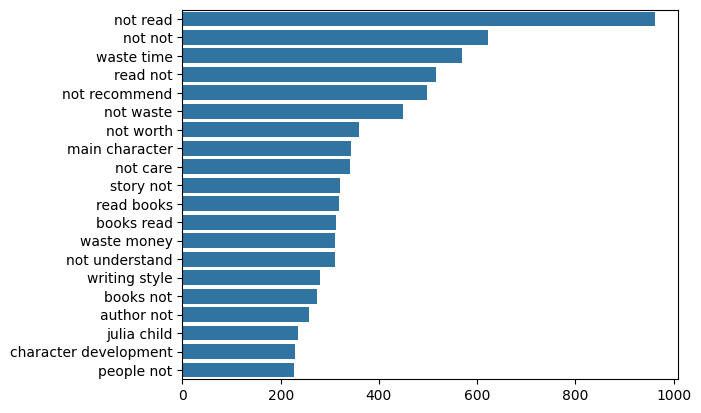

In [52]:
x, y = map(list, zip(*negative_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [53]:
negative_3_gram = get_top_ngram("negative", 3)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

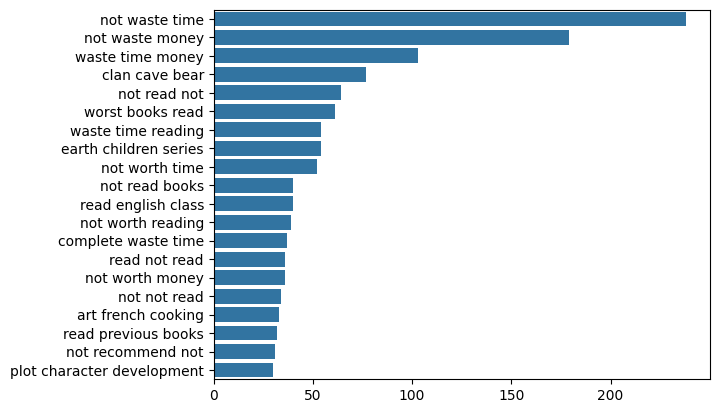

In [54]:
x, y = map(list, zip(*negative_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

## Mixed ngrams

In [55]:
mixed_1_gram = get_top_ngram("mixed", 1)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

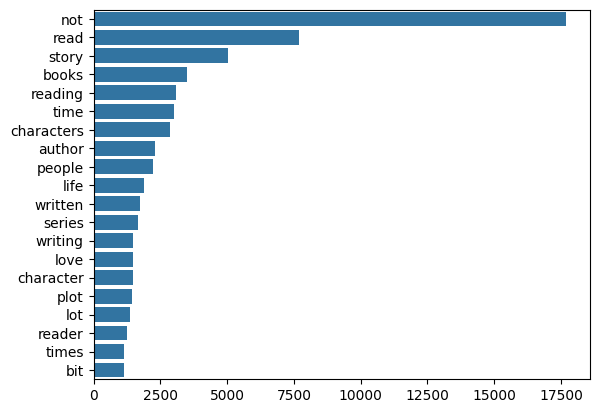

In [56]:
x, y = map(list, zip(*mixed_1_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [57]:
mixed_2_gram = get_top_ngram("mixed", 2)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

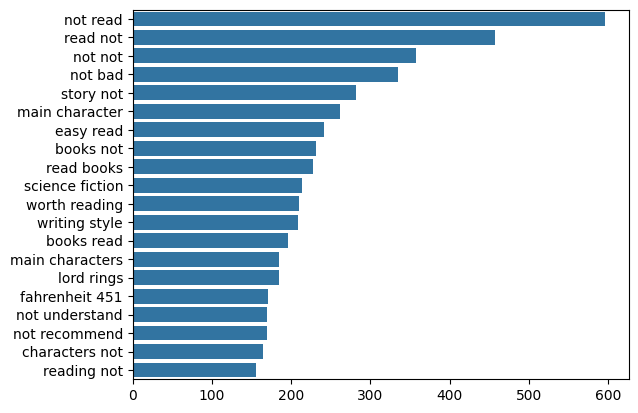

In [58]:
x, y = map(list, zip(*mixed_2_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

In [59]:
mixed_3_gram = get_top_ngram("mixed", 3)

/workspace/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['herse', 'himse', 'itse', 'mon', 'myse', 'positivea'] not in stop_words.
  warnings.warn(


<Axes: >

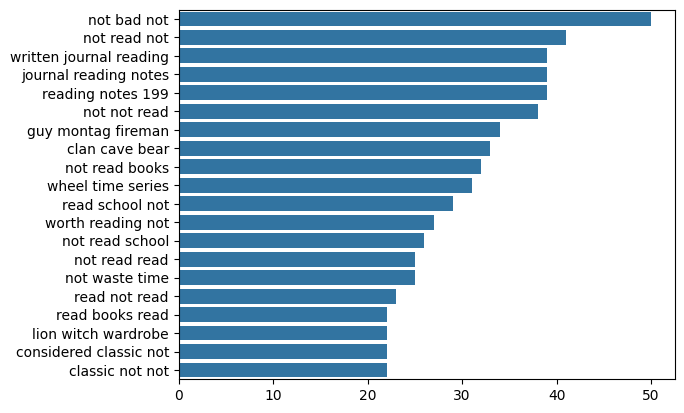

In [60]:
x, y = map(list, zip(*mixed_3_gram.words_freq[:20]))
sns.barplot(x=y, y=x)

Mixed reviews (3.0) will be removed because they cannot be classified as either positive or negative.

# Other features

In [61]:
train_data["total_length"] = train_data["reviewText"].apply(lambda x: len(x))
train_data["num_exclamation_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("!")
)
train_data["num_question_marks"] = train_data["reviewText"].apply(
    lambda comment: comment.count("?")
)
train_data["num_punctuation"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in ".,;:")
)
train_data["num_symbols"] = train_data["reviewText"].apply(
    lambda comment: sum(comment.count(w) for w in "*&$%")
)

In [22]:
train_data["mapped_sentiment"] = train_data["sentiment"].apply(
    lambda x: MAPPING_SENTIMENT_TO_NUMBER[x]
)

In [63]:
corr = train_data[train_data["sentiment"].isin(["positive", "negative"])][
    [
        "total_length",
        "num_exclamation_marks",
        "num_question_marks",
        "num_punctuation",
        "num_symbols",
        "mapped_sentiment",
    ]
].corr()

08-17 06:22 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f31a236f130>


<Axes: >

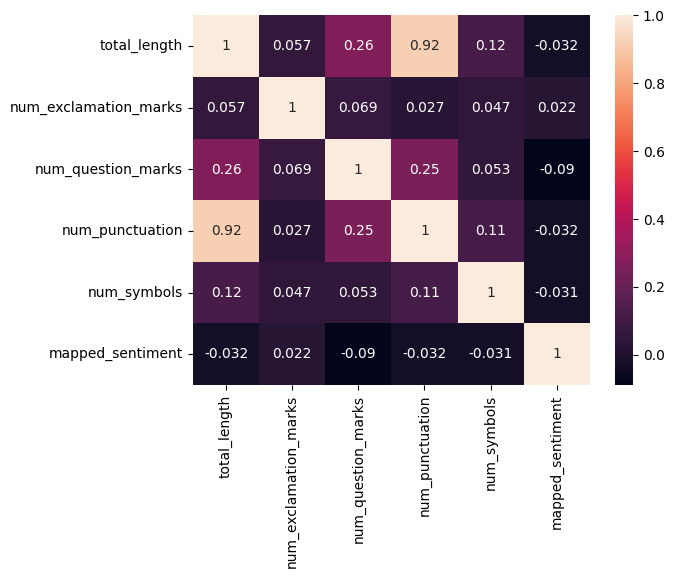

In [64]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

We can see that these features are not correlated with the mapped sentiment, which means we can remove them from the analysis.

Source of idea: https://www.kaggle.com/nz0722/simple-eda-text-preprocessing-jigsaw

# Lengths

Most of the reviews are between 0 and 500 characters length.

In [65]:
lengths = train_data.reviewText.apply(lambda x: len(x.split()))

<Axes: ylabel='Frequency'>

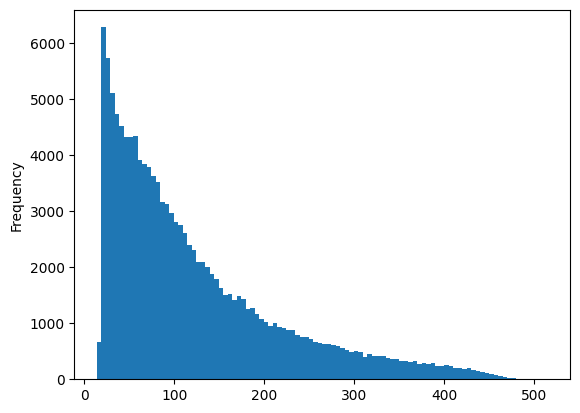

In [66]:
lengths.plot.hist(bins=100)

In [67]:
train_data["lengths"] = lengths

In [68]:
train_data = train_data[train_data["lengths"] < 1000].reset_index(drop=True)

In [69]:
train_data = train_data[
    (1000 > train_data["lengths"]) & (train_data["lengths"] > 10)
].reset_index(drop=True)

In [70]:
train_data.to_csv("../data/final_train_data.csv")

# Prepare vectors

### Load data

In [25]:
DATA_PATH = "data/final_train_data.csv"
train_data = pd.read_csv(DATA_PATH, index_col=0)

# Hyperparameter search - phase I

I will use 3 different models for benchmark - all transformers
1. **BERT**: 
2. **RoBERTA**: 
3. **Deberta**: 

In [25]:
train_data.to_csv("../data/final_train_data.csv")

In [4]:

df = pd.read_csv("../data/final_train_data.csv").sample(frac=0.01).reset_index(drop=True)
 
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for fold, (train_index, test_index) in enumerate(skf.split(X=df, y=df['mapped_sentiment'])):
    train, test = df.iloc[train_index], df.iloc[test_index]
    train.to_csv(f"../data/train_fold_{fold}.csv")
    test.to_csv(f"../data/test_fold_{fold}.csv")

In [ ]:
for model, batch_size in [
    # ["bert-base-uncased", 128],
             # [ "roberta-base", 64],/
              ["microsoft/deberta-v2-xlarge-mnli", 2] # using zero optimization
]:
    max_length  =256
    if model =="google/gemma-2-2b":
        max_length = 128
    for i in tqdm(range(5)):
        !accelerate launch ../train.py --model_name_or_path {model} --ignore_mismatched_sizes --max_length {max_length} --per_device_train_batch_size {batch_size} --learning_rate 2e-5 --num_train_epochs 1 --output_dir "/tmp/mrpc/deepspeed_stage2/" --train_file ../data/train_fold_{i}.csv --validation_file ../data/test_fold_{i}.csv --project_suffix=kfold-{i} --with_tracking --report_to "wandb"


In [1]:
from tqdm import tqdm
import pandas as pd
models = [
    "bert-base-uncased",
    "roberta-base", 
    "microsoft/deberta-v2-xlarge-mnli"
]

import wandb

api = wandb.Api()
project_name = "boulder-final-project"
from pandas import json_normalize
selected_runs = []
for model in models:
    print("trained model", model)

    for i in tqdm(range(5)):

        selected_runs.append(f'{model}-kfold-{i}')
api = wandb.Api()
runs = api.runs(f"{project_name}")
        
runs_df = []
for run in runs:
    if run.name in selected_runs:
        runs_df.append(pd.DataFrame({
            'name': [run.name],
            'config': [run.config],
            'summary_metrics': [run.summary_metrics],
            'created_at': pd.to_datetime(run.created_at)
        }))
runs_df = pd.concat(runs_df)
runs_df = runs_df.sort_values(by='created_at', ascending=False)
runs_df = runs_df.drop_duplicates(subset='name', keep='first')

runs_df = runs_df.reset_index(drop=True)

runs_df = runs_df.merge(json_normalize(runs_df['summary_metrics']), left_index=True, right_index=True)

runs_df.sort_values('eval_f1', ascending=False)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/arturtanona/.netrc


trained model bert-base-uncased


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48545.19it/s]


trained model roberta-base


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22052.07it/s]


trained model microsoft/deberta-v2-xlarge-mnli


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24272.59it/s]


,name,config,summary_metrics,created_at,_runtime,_step,_timestamp,epoch,eval_f1,eval_precision,eval_recall,step,train_loss,_wandb.runtime
2,microsoft/deberta-v2-xlarge-mnli-kfold-2,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 644.4739954471588, '_step': 2363,...",2024-08-16 16:11:47,644.473995,2363,1.723825e+09,0,0.989443,0.985140,0.993784,2363,0.095767,649
4,microsoft/deberta-v2-xlarge-mnli-kfold-0,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 659.3895955085754, '_step': 2363,...",2024-08-16 15:48:53,659.389596,2363,1.723824e+09,0,0.987785,0.985210,0.990373,2363,0.101505,664
0,microsoft/deberta-v2-xlarge-mnli-kfold-4,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 641.0197017192841, '_step': 2363,...",2024-08-16 16:34:38,641.019702,2363,1.723827e+09,0,0.987336,0.981803,0.992931,2363,0.103211,646
1,microsoft/deberta-v2-xlarge-mnli-kfold-3,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 639.7464587688446, '_step': 2363,...",2024-08-16 16:23:05,639.746459,2363,1.723826e+09,0,0.987136,0.982961,0.991347,2363,0.100538,644
3,microsoft/deberta-v2-xlarge-mnli-kfold-1,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 645.6945531368256, '_step': 2363,...",2024-08-16 16:00:29,645.694553,2363,1.723825e+09,0,0.986733,0.985534,0.987936,2363,0.103590,650
8,roberta-base-kfold-1,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 124.16269254684448, '_step': 296,...",2024-08-16 13:03:29,124.162693,296,1.723814e+09,0,0.929595,0.868452,1.000000,296,0.671175,124
9,roberta-base-kfold-0,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 122.29622626304626, '_step': 296,...",2024-08-16 13:01:04,122.296226,296,1.723813e+09,0,0.929595,0.868452,1.000000,296,0.558059,122
5,roberta-base-kfold-4,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 122.42990255355836, '_step': 296,...",2024-08-16 13:10:43,122.429903,296,1.723814e+09,0,0.929587,0.868438,1.000000,296,0.583307,122
6,roberta-base-kfold-3,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 122.02081060409546, '_step': 296,...",2024-08-16 13:08:20,122.020811,296,1.723814e+09,0,0.929587,0.868438,1.000000,296,0.599634,121
7,roberta-base-kfold-2,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 123.55626153945924, '_step': 296,...",2024-08-16 13:05:55,123.556262,296,1.723814e+09,0,0.929587,0.868438,1.000000,296,0.575579,123


In [74]:
runs_df.columns

Index(['name', 'config', 'summary_metrics', 'created_at', '_step', 'epoch',
       '_runtime', '_timestamp', 'eval_precision', 'step', 'eval_f1',
       'train_loss', 'eval_recall', '_wandb.runtime'],
      dtype='object')

In [93]:
runs_df['common_name'] = runs_df['name'].apply(lambda x: "-".join(x.split('-')[:-1]))

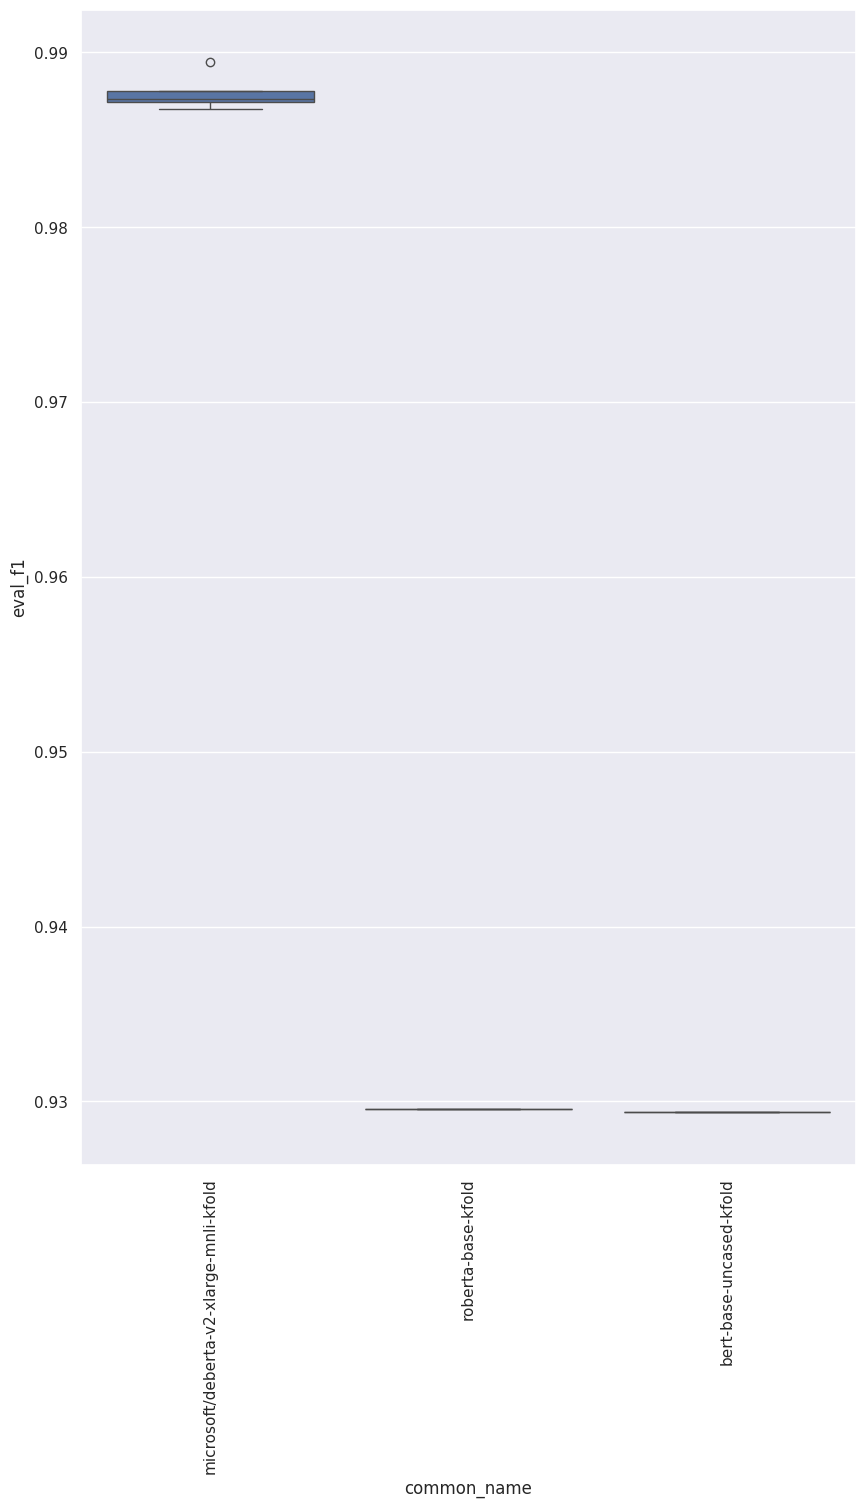

In [94]:
sns.set(rc={"figure.figsize": (10, 15)})

view = runs_df[['common_name', 'eval_f1']][runs_df['eval_f1'] > 0.9]
sns.boxplot(x='common_name', y='eval_f1', data=view, orient="v")
plt.xticks(rotation=90)
plt.show()

In [97]:
runs_df.columns

Index(['name', 'config', 'summary_metrics', 'created_at', '_step', 'epoch',
       '_runtime', '_timestamp', 'eval_precision', 'step', 'eval_f1',
       'train_loss', 'eval_recall', '_wandb.runtime', 'kfold', 'common_name'],
      dtype='object')

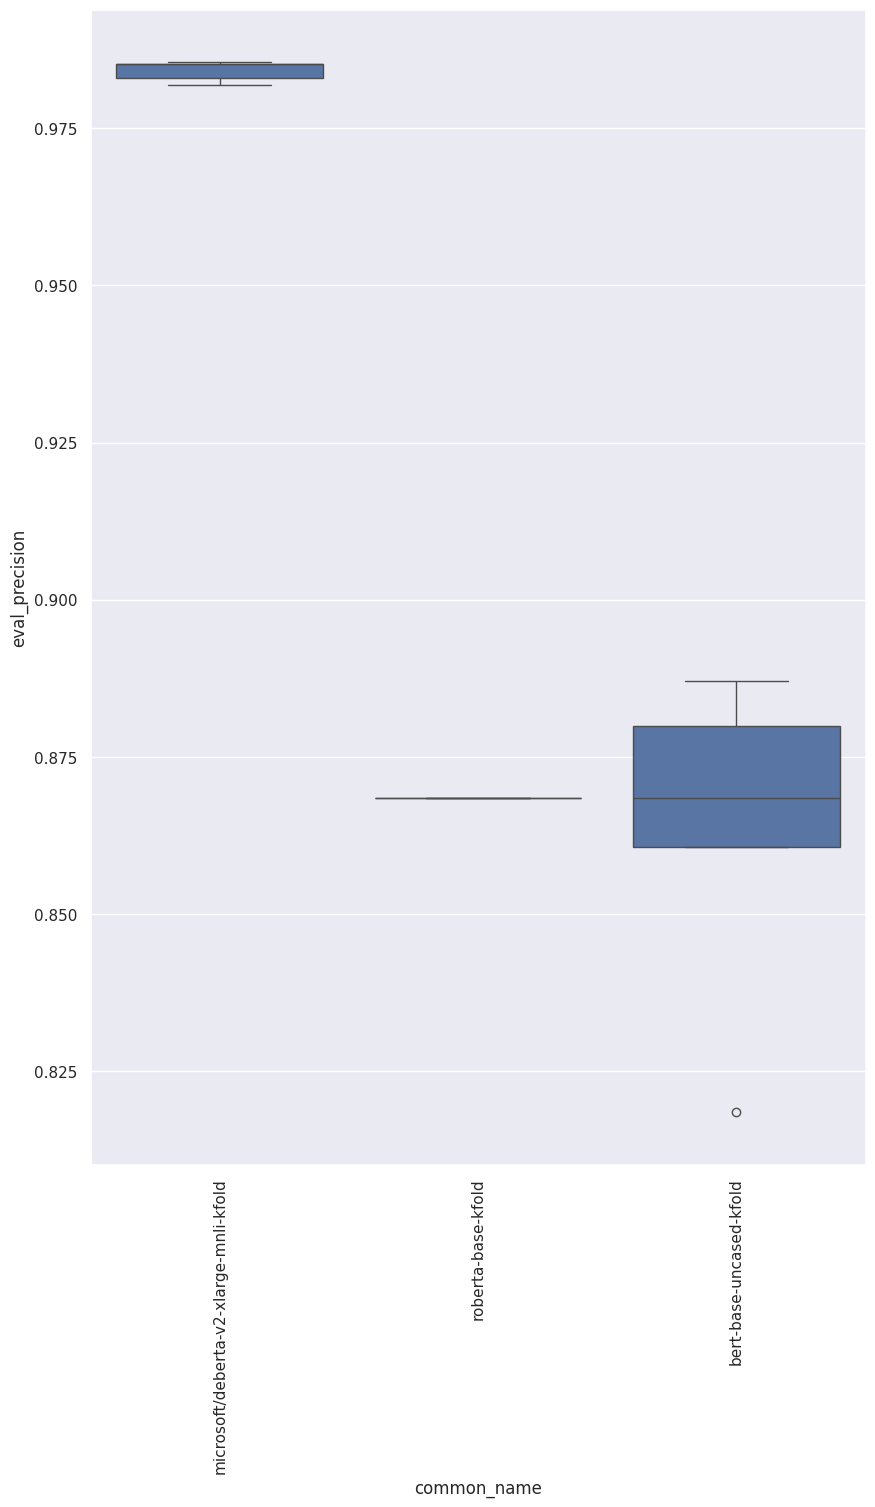

In [98]:
sns.set(rc={"figure.figsize": (10, 15)})

view = runs_df[['common_name', 'eval_precision']]
sns.boxplot(x='common_name', y='eval_precision', data=view, orient="v")
plt.xticks(rotation=90)
plt.show()

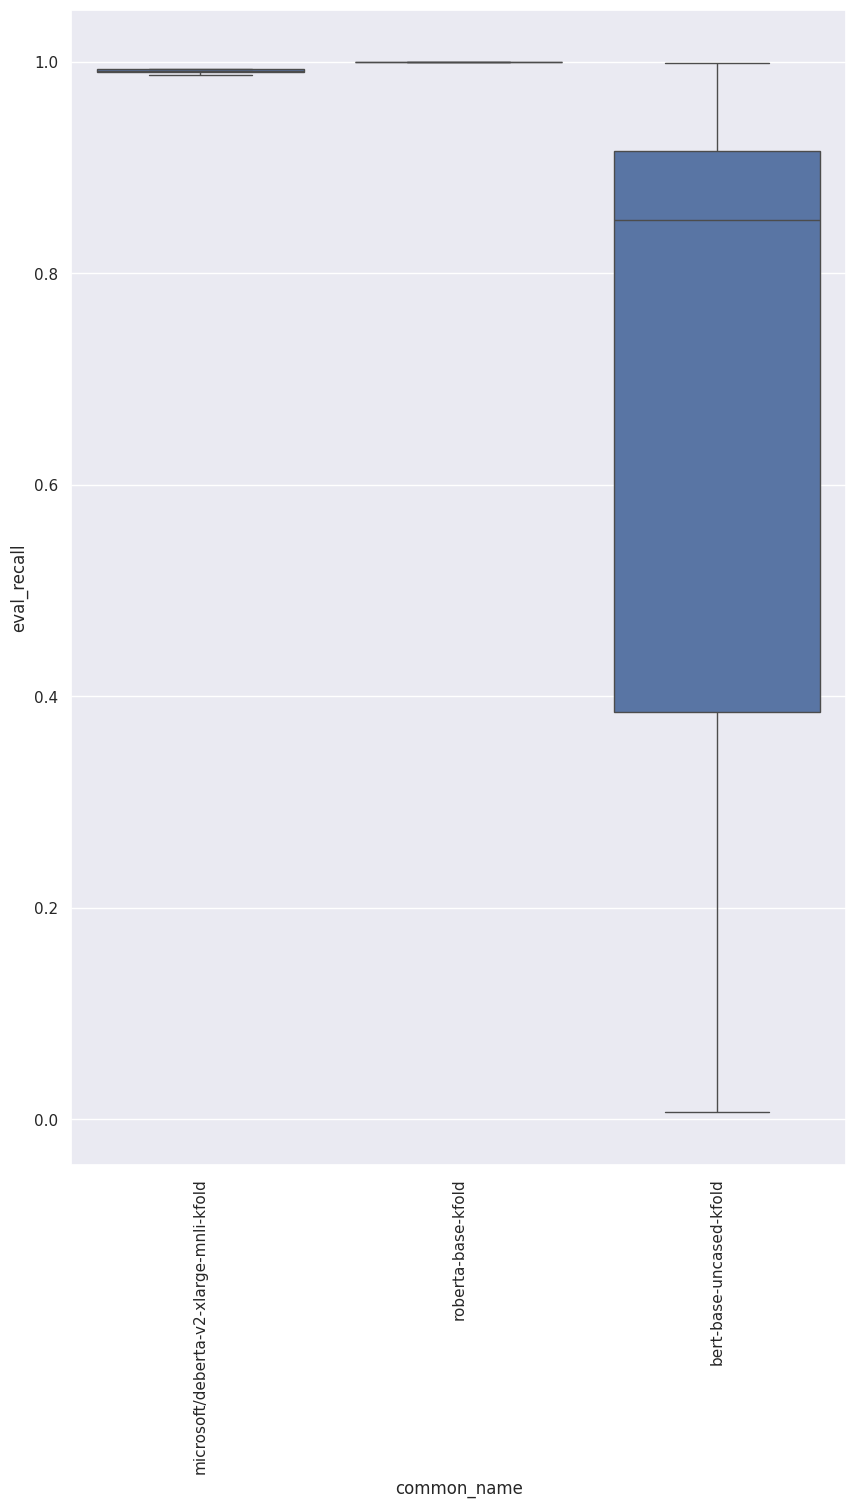

In [99]:
sns.set(rc={"figure.figsize": (10, 15)})

view = runs_df[['common_name', 'eval_recall']]
sns.boxplot(x='common_name', y='eval_recall', data=view, orient="v")
plt.xticks(rotation=90)
plt.show()

# Final model

In [27]:
df.mapped_sentiment.unique()

array([0, 2, 1])

In [12]:
df = view = pd.read_csv("../data/final_train_data.csv").reset_index(drop=True)
view = df[df['mapped_sentiment'] != 1].reset_index(drop=True)
view['mapped_sentiment'] = view['mapped_sentiment'].apply(lambda x: 1 if x == 2 else 0)
print(view.shape)
train, test, _, _ = train_test_split(view, view['mapped_sentiment'], stratify=view['mapped_sentiment'], test_size=0.1)
train.to_csv(f"../data/training_data.csv")
test.to_csv(f"../data/eval_data.csv")

(118106, 24)


In [ ]:
!accelerate launch ../train.py --model_name_or_path microsoft/deberta-v2-xlarge-mnli --ignore_mismatched_sizes --max_length 400 --per_device_train_batch_size 32 --learning_rate 2e-5 --num_train_epochs 3 --output_dir "/tmp/mrpc/deepspeed_stage2/" --train_file ../data/training_data.csv --validation_file ../data/eval_data.csv --project_suffix=final --with_tracking --report_to "wandb"

[2024-08-18 12:41:40,584] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2024-08-18 12:41:46,033] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2024-08-18 12:41:46,498] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-08-18 12:41:46,498] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
08/18/2024 12:41:46 - INFO - __main__ - Distributed environment: DEEPSPEED  Backend: nccl
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda:0

Mixed precision type: fp16
ds_config: {'train_batch_size': 'auto', 'train_micro_batch_size_per_gpu': 'auto', 'gradient_accumulation_steps': 1, 'zero_optimization': {'stage': 2, 'offload_optimizer': {'device': 'none', 'nvme_path': None}, 'offload_param': {'device': 'cpu', 'nvme_path': None}, 'stage3_gather_16bit_weights_on_model_save': False}, 'gradient_clipping': 1.0, 'steps_per_print': inf, 'fp16': 

# Final model comparison


It got me the 0.99 F1 score and very high  after 3 epochs

In [10]:

api = wandb.Api()
project_name = "boulder-final-project"
from pandas import json_normalize
selected_runs = []
for model in models:
    print("trained model", model)

    for i in tqdm(range(5)):

        selected_runs.append(f'{model}-kfold-{i}')
api = wandb.Api()
runs = api.runs(f"{project_name}")
        
runs_df = []
for run in runs:
    if ('final') in run.name:
        runs_df.append(pd.DataFrame({
            'name': [run.name],
            'config': [run.config],
            'summary_metrics': [run.summary_metrics],
            'created_at': pd.to_datetime(run.created_at)
        }))

trained model bert-base-uncased


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48998.88it/s]


trained model roberta-base


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75709.46it/s]


trained model microsoft/deberta-v2-xlarge-mnli


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]


In [11]:
runs_df = pd.concat(runs_df)
runs_df = runs_df.sort_values(by='created_at', ascending=False)
runs_df = runs_df.drop_duplicates(subset='name', keep='first')

runs_df = runs_df.reset_index(drop=True)

runs_df = runs_df.merge(json_normalize(runs_df['summary_metrics']), left_index=True, right_index=True)

runs_df.sort_values('eval_f1', ascending=False)

,name,config,summary_metrics,created_at,_runtime,_step,_timestamp,epoch,eval_f1,eval_precision,eval_recall,step,train_loss,_wandb.runtime
0,microsoft/deberta-v2-xlarge-mnli-final,"{'seed': None, 'hub_token': None, 'report_to':...","{'_runtime': 9781.683929920197, '_step': 9966,...",2024-08-18 12:43:36,9781.68393,9966,1.723995e+09,2,0.991068,0.98886,0.993286,9966,0.023043,9784


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("deepspeed_stage2")

tokenizer = AutoTokenizer.from_pretrained("deepspeed_stage2")

In [35]:
df = view = pd.read_csv("data/final_train_data.csv").reset_index(drop=True)
view = df[df['mapped_sentiment'] != 1].reset_index(drop=True)
view['mapped_sentiment'] = view['mapped_sentiment'].apply(lambda x: 1 if x == 2 else 0)

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


sentences = view.text_lematized.tolist()
batch_size = 8
preds = []
total_logits = []
for i in tqdm(range(0, len(sentences[:16]), batch_size)):
    batch = sentences[i:i+batch_size]
    inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    for j, sentence in enumerate(batch):
        logit = logits[j]
        total_logits.append(logit)
        pred_class = torch.argmax(logit, dim=-1).item()
        preds.append(pred_class)

  0%|                             | 0/2 [00:00<?, ?it/s]

In [ ]:
# load model and run the below things 
# load data 

In [37]:
labels = view.mapped_sentiment[:16]

In [41]:
confusion_matrix(labels, preds), f1_score(labels, preds)

(array([[ 2,  0],
        [ 0, 14]]),
 1.0)

In [ ]:
y_test = test_items["mapped_sentiment"].apply(lambda x: 1 if x == 2 else 0)
y_hat = model.predict(test_vectors)
confusion_matrix(y_test, y_hat), f1_score(y_test, y_hat)

# Discussion and Conclusion

On the validation set selected from training data, f1_score was about 0.89, the classificator perform good at targeting `positive` example, however it should be optimized against indication of `negative`  example. 

The selected model was LR model because of pretty good behaviour during cross validation and my decision of using CPU. Probably better result can be achieved:
* via transformers
* better preprocessing of data (keeping some NERs)
* clustering documents and apply separate model for each bucket/cluster
* longer training and longer hyperparameter optimization 
* manipulating threshold of probability indicated in model

# Source

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

https://stats.stackexchange.com/questions/389865/how-to-distinguish-overfitting-and-underfitting-from-the-roc-auc-curve